In [1]:
from datasets import load_dataset # pip install datasets
from pathlib import Path
from collections import Counter
from datasets import Dataset, DatasetDict
import numpy as np
import jsonlines #pip install jsonlines
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import ast
import evaluate
from nervaluate import Evaluator
import pandas as pd
import plotly.graph_objects as go
from transformers import DataCollatorWithPadding
import seqeval.metrics as seqeval
from pynvml import *
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import warnings
warnings.filterwarnings("ignore")

c:\Users\mdurango\AppData\Local\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 🔓 Decode labels y formato BIO

In [2]:

data_dir =  Path("D:/Users/MDurango/OneDrive - Materialise NV/Materialise Git/Cardiac segmentation Unet2D/FastAPI/Finetuning-NER")
train_path = data_dir / "training_anns_bio.csv"
test_path = data_dir / "testing_anns_bio.json"
val_path = data_dir / "development_anns_bio.json"

# training dataset
train_data = pd.read_csv(train_path, delimiter= "\t", header=None, names=['labels', 'tokens'])
labels_train = []
sentences_train= []

for labels, sentences in zip(train_data["labels"], train_data["tokens"]):
    labels_train.append(ast.literal_eval(labels))
    sentences_train.append(ast.literal_eval(sentences))

# test dataset 
with jsonlines.open(test_path) as f:
    test_data = list(f)

labels_test = [obj["ner_tags"] for obj in test_data]
sentences_test = [obj["tokens"] for obj in test_data]

# validation dataset
with jsonlines.open(val_path) as f:
    val_data = list(f)

labels_val = [obj["ner_tags"] for obj in val_data]
sentences_val = [obj["tokens"] for obj in val_data]


In [3]:

def count_labels(labels):
    flattened_labels = [label for sublist in labels for label in sublist]
    return Counter(flattened_labels)




In [4]:
print("Labels en validación: ", count_labels(labels_val))
print("Labels en test: ", count_labels(labels_test))
print("Labels en train: ", count_labels(labels_train))

Labels en validación:  Counter({'O': 1841, 'B-Concept': 797, 'B-Action': 340, 'I-Concept': 205, 'B-Predicate': 124, 'B-Reference': 44, 'I-Predicate': 5, 'I-Action': 4})
Labels en test:  Counter({'O': 811, 'B-Concept': 377, 'B-Action': 121, 'I-Concept': 85, 'B-Predicate': 49, 'B-Reference': 9, 'I-Predicate': 8, 'I-Action': 3})
Labels en train:  Counter({'O': 7119, 'B-Concept': 3104, 'B-Action': 1319, 'I-Concept': 749, 'B-Predicate': 412, 'B-Reference': 169, 'I-Predicate': 20, 'I-Action': 10})


In [5]:
# label encoding

# ent_label: type of entity (Concept, Action, Predicate or Reference)

idx2label = {
    0: "O",
    1: "B-Concept", 
    2: "I-Concept", 
    3: "B-Action", 
    4: "I-Action", 
    5: "B-Predicate", 
    6: "I-Predicate",
    7: "B-Reference"

}
label2idx = {v: k for k, v in idx2label.items()}

In [6]:
label2idx


{'O': 0,
 'B-Concept': 1,
 'I-Concept': 2,
 'B-Action': 3,
 'I-Action': 4,
 'B-Predicate': 5,
 'I-Predicate': 6,
 'B-Reference': 7}

In [7]:
# muestra de tokens en sentencia con sus respectivas labels
# num labels = num tokens en dicha sentencia

print(labels_train[0])
print(f"Número de labels {len(labels_train[0])}")
print(sentences_train[0])
print(f"Número de tokens {len(sentences_train[0])}")

print(labels_val[0])
print(f"Número de labels {len(labels_val[0])}")
print(sentences_val[0])
print(f"Número de tokens {len(sentences_val[0])}")

print(labels_test[0])
print(f"Número de labels {len(labels_test[0])}")
print(sentences_test[0])
print(f"Número de tokens {len(sentences_test[0])}")





['O', 'O', 'B-Concept', 'I-Concept', 'I-Concept', 'O', 'O', 'O', 'B-Concept', 'O', 'O', 'O', 'O', 'B-Concept', 'I-Concept', 'O']
Número de labels 16
['en', 'la', 'leucemia', 'linfocítica', 'crónica', ',', 'hay', 'demasiados', 'linfocitos', ',', 'un', 'tipo', 'de', 'glóbulos', 'blancos', '.']
Número de tokens 16
['B-Reference', 'O', 'O', 'O', 'B-Predicate', 'O', 'B-Concept', 'O', 'O', 'O', 'O', 'B-Concept', 'O', 'O', 'B-Action', 'B-Concept', 'O', 'O', 'O', 'B-Concept', 'O', 'O', 'B-Concept', 'O', 'O', 'O']
Número de labels 26
['los', 'que', 'se', 'encuentran', 'dentro', 'del', 'cuerpo', 'pueden', 'quizá', 'no', 'ser', 'obvios', 'y', 'pueden', 'lesionar', 'órganos', ',', 'incluso', 'el', 'cerebro', ',', 'los', 'pulmones', 'y', 'otros', '.']
Número de tokens 26
['O', 'O', 'B-Concept', 'O', 'B-Predicate', 'B-Concept', 'O', 'B-Predicate', 'O', 'B-Predicate', 'O', 'B-Action', 'B-Predicate', 'B-Concept', 'B-Action', 'O', 'B-Concept', 'O']
Número de labels 18
['todas', 'las', 'personas', 'de',

Creación del dataset:

In [8]:
train_dataset = Dataset.from_dict(
    {
        "inputs": sentences_train,
        "output": labels_train
    }
)

test_dataset = Dataset.from_dict(
    {
        "inputs": sentences_test,
        "output": labels_test
    }
)

val_dataset = Dataset.from_dict(
    {
        "inputs": sentences_val,
        "output": labels_val
    }
)

train_test_valid_dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset, 
    "validation": val_dataset,
})


In [9]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['inputs', 'output'],
        num_rows: 800
    })
    test: Dataset({
        features: ['inputs', 'output'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['inputs', 'output'],
        num_rows: 199
    })
})

### Config model

In [10]:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Device:', device)

Device: cuda


In [11]:
num_labels = len(idx2label)
model_name = "PlanTL-GOB-ES/bsc-bio-ehr-es-cantemist" # name model from hugging face
# PlanTL-GOB-ES/bsc-bio-ehr-es-cantemist
# "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [12]:
# Cargar el modelo pre-entrenado
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True).to("cuda")
# # pip install --no-cache-dir --force-reinstall Pillow

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/bsc-bio-ehr-es-cantemist and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [14]:
def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")
    
print_gpu_utilization()

GPU memory occupied: 2265 MB.


In [15]:
model.config.id2label  = idx2label
model.config.label2idx = label2idx

In [16]:
sentences_len_train = [len(sentences_len) for sentences_len in train_test_valid_dataset["train"]["inputs"]]
fig = go.Figure(data=[go.Histogram(x=sentences_len_train)])
fig.update_layout(title_text='Distribución de la cantidad de tokens en el conjunto de entrenamiento')
fig.show()

In [17]:
# preparar la data 
# considerar: max len, padding, mask attention
# max len es la longitud máxima que se permitirá para una seceuncia de entrada. Si una sentencia es más larga que tal valor, se truncará y se rellena con padding
# padding es el procesos de agregar tokens de relleno a las sencuencias inferiores a max len
# mas attention es un mecanimos que permite que nuestro modelo ignore los oktens de relleno durante el entrenamiento y la inferencia y no se presta atención 
# para el calculo del error o función de coste

def tokenize_and_aling_labels(examples, input_column_name,output_column_name, 
                            padding,  max_length, label_to_id, label_all_tokens):
    """
    examples
    input columns names: sentences list 
    output column name: true labels with BIO format list
    max_length 
    label_to_id: dictionary decoding label into int
    label_all_tokens
    """ 
    tokenized_inputs= tokenizer(examples[input_column_name], 
                                padding = padding, 
                                truncation= True,
                                max_length= max_length,
                                is_split_into_words= True,
                                return_tensors= "pt"
                                )
    labels = []
    for i, label in enumerate(examples[output_column_name]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        previous_word_idx = None
        labels_ids = []
        for word_idx in word_ids:
            # para los tokens que tienen word id None, fijar label a -100 para ignorarlos en loss function
            if word_idx is None:
                labels_ids.append(-100)
            # fijar el id basado en la label para codificar en int basados en label2idx
            elif word_idx != previous_word_idx:
                labels_ids.append(label_to_id[label[word_idx]])

            else:
                labels_ids.append(label_to_id[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(labels_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
train_test_valid_dataset_align = train_test_valid_dataset.map(tokenize_and_aling_labels,
            fn_kwargs = dict(
            input_column_name = "inputs",
            padding = "max_length", 
            output_column_name = "output", 
            max_length = 30, 
            label_to_id = label2idx, 
            label_all_tokens = False
            ),
            batched=True,
        )
train_test_valid_dataset_align

DatasetDict({
    train: Dataset({
        features: ['inputs', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['inputs', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['inputs', 'output', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 199
    })
})

In [19]:
train_test_valid_dataset_align["train"]["labels"][0]

[-100,
 0,
 0,
 1,
 2,
 2,
 0,
 -100,
 0,
 0,
 1,
 0,
 -100,
 0,
 0,
 0,
 1,
 2,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100]

In [20]:
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis= -1)

    # remover tokens especiales (padding, especial tokens)
    true_predictions = []
    true_labels  = []
    for row_pred, row_lab in zip(predictions, labels): 
        for dat_pred, dat_lab in zip(row_pred, row_lab):
            if dat_lab != -100:
                true_predictions.append(dat_pred)
                true_labels.append(dat_lab)

    return metric.compute(predictions= true_predictions, references = true_labels, average = "macro")
        


In [21]:
list(model.classifier.named_parameters())

[('weight',
  Parameter containing:
  tensor([[-0.0104,  0.0269, -0.0043,  ...,  0.0056,  0.0160,  0.0253],
          [-0.0332, -0.0110,  0.0070,  ..., -0.0264,  0.0105,  0.0127],
          [-0.0258, -0.0243, -0.0327,  ...,  0.0230,  0.0060, -0.0094],
          ...,
          [ 0.0225,  0.0260,  0.0190,  ..., -0.0007,  0.0119,  0.0339],
          [-0.0094, -0.0354,  0.0194,  ...,  0.0159,  0.0089, -0.0217],
          [-0.0069,  0.0209, -0.0217,  ..., -0.0218,  0.0220,  0.0162]],
         device='cuda:0', requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0272, -0.0336, -0.0240, -0.0136,  0.0338, -0.0166,  0.0277, -0.0093],
         device='cuda:0', requires_grad=True))]

In [22]:
def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

### 💻 Preparando fase de entrenamiento

In [23]:
default_args = {
    "output_dir": "./results",
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch", 
    "num_train_epochs": 15,
    "per_device_train_batch_size": 32,
    "per_device_eval_batch_size": 8, 
   # "log_level": "info", # o "debug"
    "load_best_model_at_end": True,
  #  "weight_decay": 0.01,
}


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(fp16=True, **default_args)
trainer = Trainer(model=model, args=training_args, 
                  train_dataset=train_test_valid_dataset_align["train"],
                  eval_dataset=train_test_valid_dataset_align["validation"],
                  compute_metrics= compute_metrics,
                  data_collator=data_collator, 
                  tokenizer=tokenizer
                  )

trainer.add_callback(EarlyStoppingCallback(1, 0.0001))
result = trainer.train()

print_summary(result)

  0%|          | 0/375 [00:00<?, ?it/s]You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                
  7%|▋         | 25/375 [00:03<00:31, 11.07it/s]

{'eval_loss': 0.5650594234466553, 'eval_f1': 0.3783075037924354, 'eval_runtime': 0.4289, 'eval_samples_per_second': 463.961, 'eval_steps_per_second': 58.287, 'epoch': 1.0}


                                                
 13%|█▎        | 50/375 [00:11<00:28, 11.44it/s]

{'eval_loss': 0.3753697872161865, 'eval_f1': 0.5159368464620934, 'eval_runtime': 0.4506, 'eval_samples_per_second': 441.6, 'eval_steps_per_second': 55.477, 'epoch': 2.0}


                                                
 20%|██        | 75/375 [00:23<00:31,  9.38it/s]

{'eval_loss': 0.3405446708202362, 'eval_f1': 0.5960049313278073, 'eval_runtime': 0.4448, 'eval_samples_per_second': 447.349, 'eval_steps_per_second': 56.2, 'epoch': 3.0}


                                                 
 27%|██▋       | 100/375 [00:39<00:29,  9.33it/s]

{'eval_loss': 0.33759236335754395, 'eval_f1': 0.6157799585565211, 'eval_runtime': 0.4229, 'eval_samples_per_second': 470.511, 'eval_steps_per_second': 59.109, 'epoch': 4.0}


                                                 
 33%|███▎      | 125/375 [00:52<00:26,  9.53it/s]

{'eval_loss': 0.3643116056919098, 'eval_f1': 0.6065784915110273, 'eval_runtime': 0.465, 'eval_samples_per_second': 427.987, 'eval_steps_per_second': 53.767, 'epoch': 5.0}


 33%|███▎      | 125/375 [01:06<02:13,  1.87it/s]

{'train_runtime': 66.7631, 'train_samples_per_second': 179.74, 'train_steps_per_second': 5.617, 'train_loss': 0.4166098937988281, 'epoch': 5.0}
Time: 66.76
Samples/second: 179.74
GPU memory occupied: 4905 MB.


In [24]:
metrics = trainer.evaluate(train_test_valid_dataset_align['test'])
trainer.log_metrics("test", metrics)

100%|██████████| 13/13 [00:00<00:00, 50.96it/s]

***** test metrics *****
  epoch                   =        5.0
  eval_f1                 =     0.6626
  eval_loss               =     0.3486
  eval_runtime            = 0:00:00.54
  eval_samples_per_second =    184.343
  eval_steps_per_second   =     23.965


In [25]:
for obj in trainer.state.log_history: 
    print(obj)

{'eval_loss': 0.5650594234466553, 'eval_f1': 0.3783075037924354, 'eval_runtime': 0.4289, 'eval_samples_per_second': 463.961, 'eval_steps_per_second': 58.287, 'epoch': 1.0, 'step': 25}
{'eval_loss': 0.3753697872161865, 'eval_f1': 0.5159368464620934, 'eval_runtime': 0.4506, 'eval_samples_per_second': 441.6, 'eval_steps_per_second': 55.477, 'epoch': 2.0, 'step': 50}
{'eval_loss': 0.3405446708202362, 'eval_f1': 0.5960049313278073, 'eval_runtime': 0.4448, 'eval_samples_per_second': 447.349, 'eval_steps_per_second': 56.2, 'epoch': 3.0, 'step': 75}
{'eval_loss': 0.33759236335754395, 'eval_f1': 0.6157799585565211, 'eval_runtime': 0.4229, 'eval_samples_per_second': 470.511, 'eval_steps_per_second': 59.109, 'epoch': 4.0, 'step': 100}
{'eval_loss': 0.3643116056919098, 'eval_f1': 0.6065784915110273, 'eval_runtime': 0.465, 'eval_samples_per_second': 427.987, 'eval_steps_per_second': 53.767, 'epoch': 5.0, 'step': 125}
{'train_runtime': 66.7631, 'train_samples_per_second': 179.74, 'train_steps_per_se

### Evaluación del modelo

In [26]:
with torch.no_grad():
    logits = model(
                input_ids = torch.tensor(train_test_valid_dataset_align["test"]["input_ids"]).to("cuda"),
                attention_mask = torch.tensor(train_test_valid_dataset_align["test"]["attention_mask"]).to("cuda")
                ).logits.to("cpu")

eval_pred = (logits,train_test_valid_dataset_align["test"]["labels"])
f1_test = compute_metrics(eval_pred)
f1_test

{'f1': 0.6635071695884707}

In [27]:
logits.shape #samples en test, max len, #num labels

torch.Size([100, 30, 8])

In [28]:
# añadamos todas las predicciones en test para sacar métricas de acuerdo al NER task 
predictions = np.argmax(logits, axis= -1)
true_predictions = []
true_labels = []

for row_pred, row_lab in zip(predictions, train_test_valid_dataset_align["test"]["labels"]):
    for dat_pred, dat_lab in zip(row_pred, row_lab):
        if dat_lab != -100:
            true_predictions.append(dat_pred)
            true_labels.append(dat_lab)

true_predictions_names = [idx2label[idx.item()] for idx in true_predictions]
true_labels_names = [idx2label[idx] for idx in true_labels]

In [29]:

sentence = train_test_valid_dataset_align["test"]["inputs"][5]
predictions_labels = [idx2label[idx.item()] for idx in predictions[5]]
real_labels =  train_test_valid_dataset_align["test"]["output"][5]
print(f"sentence: {' '.join(sentence)}")
print(f"predictions: {' '.join(predictions_labels)}")
print(f"real labels: {' '.join(real_labels)}")



sentence: el síndrome de dolor regional complejo es un trastorno de dolor crónico .
predictions: O O B-Concept I-Concept I-Concept I-Concept I-Concept O O B-Concept O B-Concept I-Concept O O O O O O O O O O O O O O O O O
real labels: O B-Concept I-Concept I-Concept I-Concept I-Concept O O B-Concept O B-Concept B-Concept O


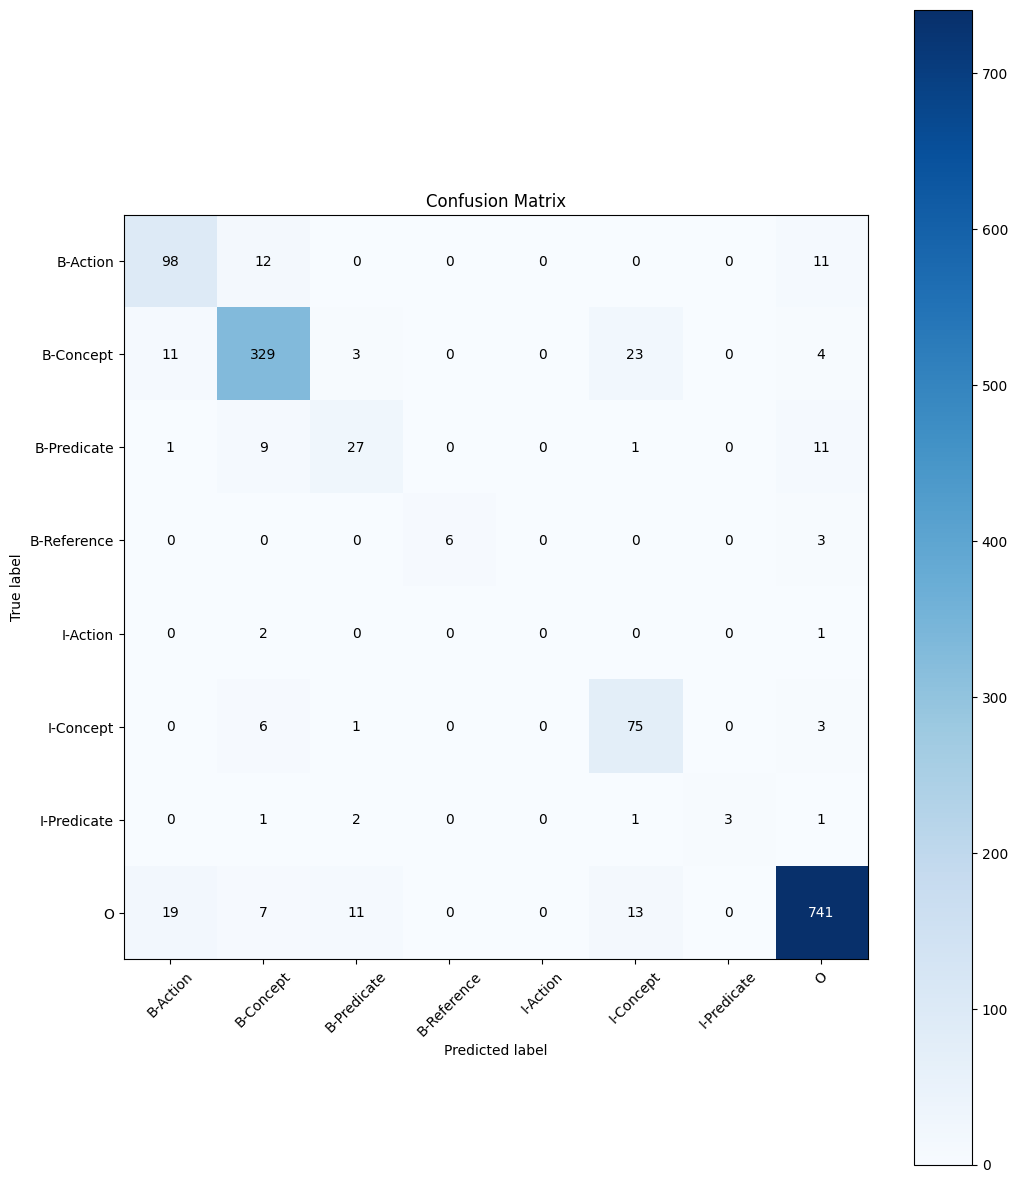

In [30]:
skplt.metrics.plot_confusion_matrix(true_labels_names, true_predictions_names, figsize=(12,15),x_tick_rotation=45)  
plt.show()

In [31]:
seqeval = evaluate.load('seqeval')
results = seqeval.compute(predictions=[true_predictions_names], references= [true_labels_names])

In [32]:
results

{'Action': {'precision': 0.7441860465116279,
  'recall': 0.7933884297520661,
  'f1': 0.768,
  'number': 121},
 'Concept': {'precision': 0.8413978494623656,
  'recall': 0.845945945945946,
  'f1': 0.8436657681940701,
  'number': 370},
 'Predicate': {'precision': 0.5681818181818182,
  'recall': 0.5102040816326531,
  'f1': 0.5376344086021506,
  'number': 49},
 'Reference': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1': 0.8,
  'number': 9},
 'overall_precision': 0.7985480943738656,
 'overall_recall': 0.8014571948998178,
 'overall_f1': 0.7999999999999998,
 'overall_accuracy': 0.8906685236768802}

In [33]:
evaluator = Evaluator([true_labels_names], [true_predictions_names], tags= ['Action',
                            'Concept',
                            'Predicate'],
                      loader="list")

# Returns overall metrics and metrics for each tag

results, results_per_tag = evaluator.evaluate()

print(results)


{'ent_type': {'correct': 457, 'incorrect': 37, 'partial': 0, 'missed': 46, 'spurious': 51, 'possible': 540, 'actual': 545, 'precision': 0.8385321100917431, 'recall': 0.8462962962962963, 'f1': 0.8423963133640554}, 'partial': {'correct': 460, 'incorrect': 0, 'partial': 34, 'missed': 46, 'spurious': 51, 'possible': 540, 'actual': 545, 'precision': 0.8752293577981651, 'recall': 0.8833333333333333, 'f1': 0.87926267281106}, 'strict': {'correct': 434, 'incorrect': 60, 'partial': 0, 'missed': 46, 'spurious': 51, 'possible': 540, 'actual': 545, 'precision': 0.7963302752293578, 'recall': 0.8037037037037037, 'f1': 0.8}, 'exact': {'correct': 460, 'incorrect': 34, 'partial': 0, 'missed': 46, 'spurious': 51, 'possible': 540, 'actual': 545, 'precision': 0.8440366972477065, 'recall': 0.8518518518518519, 'f1': 0.847926267281106}}


💡 Para mayor información sobre métricas para modelos NER, te dejo este increíble blog: https://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/


👆 Modelo implementado https://huggingface.co/PlanTL-GOB-ES/bsc-bio-ehr-es-pharmaconer

🚀 El uso de modelos pre-entrenados de lenguaje, especialmente basados en la arquitectura Transformer, es una estrategia muy efectiva para abordar tareas de procesamiento de lenguaje natural (NLP). Con técnicas de finetuning, podemos adaptar estos modelos a nuestros datos específicos y obtener excelentes resultados en tareas como NER.

¡Gracias por tu participación!